In [1]:
import tensorflow as tf
from tensorflow.contrib import slim
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from collections import OrderedDict
import torchvision.transforms as transforms
from old_generator import TorchGAN

%load_ext autoreload
%autoreload 2

In [ ]:
# os.system("gdown --id 1TE1Bi5ym-TbLSnlkAAOP0sSQYkgTNl4A --output datasets/omniglot_data.npy")
# os.system("mkdir checkpoints")
# os.system("gdown --id 1qw_op6L2RebrGik0cBWquDK3RTculrVR --output checkpoints/model.ckpt.data-00000-of-00001")
# os.system("gdown --id 17UFRFwWOyJ_-tU72SH0o5mrg2-oEra95 --output checkpoints/model.ckpt.index")
# os.system("gdown --id 1iSOAjMUWLDemHljNHk0grCFdblSArBcP --output checkpoints/model.ckpt.meta")

In [2]:
z = np.ones((1, 100)) * 0.5

In [3]:
raw_data = np.load("datasets/omniglot_data.npy")

In [4]:
inp = np.array([raw_data[1200][0]], dtype="float64")

In [5]:
from dagan_architectures import UResNetGenerator, Discriminator

g = UResNetGenerator(batch_size=1, layer_sizes=[64, 64, 128, 128], layer_padding=None,
                        inner_layers=[3] * 4, name="generator")

In [6]:
z_inp = tf.placeholder(tf.float32, [1,100], 'z-inp')
cond_inp = tf.placeholder(tf.float32, [1,28,28,1], 'cond-inp')

In [7]:
result = g(z_inp, cond_inp, training=False)


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.Dense instead.
Tensor("generator/vector_expansion/Reshape:0", shape=(1, 2, 2, 8), dtype=float32)
Tensor("generator/vector_expansion/Reshape_1:0", shape=(1, 4, 4, 4), dtype=float32)
Tensor("generator/vector_expansion/Reshape_2:0", shape=(1, 7, 7, 2), dtype=float32)
Tensor("generator/vector_expansion/Reshape_3:0", shape=(1, 14, 14, 1), dtype=float32)

Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


generator_total_layers 50
generator_parameter_num 10546217


In [8]:
torch_g = TorchGAN(dim=28, channels=1)
torch_g.eval()

TorchGAN(
  (encode0): Sequential(
    (pad): _SamePad()
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (relu): LeakyReLU(negative_slope=0.2)
    (batchnorm): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (encode1): _EncoderBlock(
    (pre_conv): Sequential(
      (pad): _SamePad()
      (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
    )
    (conv0): Sequential(
      (pad): _SamePad()
      (conv): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1))
      (relu): LeakyReLU(negative_slope=0.2)
      (batchnorm): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    )
    (conv1): Sequential(
      (pad): _SamePad()
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (relu): LeakyReLU(negative_slope=0.2)
      (batchnorm): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (pad): _SamePad()
      (conv): 

In [9]:
checkpoint = "checkpoints/checkpoint.ckpt"
ckpt_reader = tf.train.load_checkpoint(checkpoint)
def read_tf(var):
    return torch.tensor(ckpt_reader.get_tensor(var))

def reshape_conv(tensor):
    return tensor.transpose(0, 3).transpose(1, 2).transpose(2, 3)

In [10]:
# Seed torch generator weights

def convert_conv_layer(torch_layer, conv_path, bn_path=None):
    if bn_path is not None:
        torch_layer.batchnorm.weight.data = read_tf(bn_path + "/gamma")
        torch_layer.batchnorm.bias.data = read_tf(bn_path + "/beta")
        torch_layer.batchnorm.running_mean = read_tf(bn_path + "/moving_mean")
        torch_layer.batchnorm.running_var = read_tf(bn_path + "/moving_variance")
    
    torch_layer.conv.weight.data = reshape_conv(read_tf(conv_path + "/kernel"))
    torch_layer.conv.bias.data = read_tf(conv_path + "/bias")
    
num_layers = torch_g.num_inner_layers

# Encoders
convert_conv_layer(
    torch_g.encode0, "generator/conv_layers/g_conv0/conv2d", "generator/conv_layers/g_conv0/BatchNorm")

for i in range(1, torch_g.U_depth):
    module = torch_g._modules["encode%d" % i]
    convert_conv_layer(
        module.pre_conv,
        f"generator/conv_layers/g_conv{i}/conv2d"
    )

    for j in range(num_layers + 1):
        bn_suffix = f"_{j}" if j > 0 else ""
        convert_conv_layer(
            module._modules[f"conv{j}"],
            f"generator/conv_layers/g_conv{i}/conv2d_{j + 1}",
            f"generator/conv_layers/g_conv{i}/BatchNorm{bn_suffix}",
        )

# Noise encoders
for i in range(torch_g.noise_encoders):
    module = torch_g._modules["z_reshape%d" % i]
    z_suffix = f"_{i}" if i > 0 else ""
    module.weight.data = read_tf(f"generator/vector_expansion/dense{z_suffix}/kernel").T
    module.bias.data = read_tf(f"generator/vector_expansion/dense{z_suffix}/bias").T


# Decoders
for i in range(torch_g.U_depth + 1):
    module = torch_g._modules["decode%d" % i]

    for j in range(num_layers):
        idx_suffix = f"_{j}" if j > 0 else ""
        if i > 0:
            convert_conv_layer(
                module._modules[f"pre_conv_t{j}"],
                f"generator/g_deconv_layers/g_deconv{i}/conv2d_transpose{idx_suffix}",
            )
        convert_conv_layer(
            module._modules[f"conv{j}"],
            f"generator/g_deconv_layers/g_deconv{i}/conv2d{idx_suffix}",
            f"generator/g_deconv_layers/g_deconv{i}/BatchNorm{idx_suffix}",
        )
    if i < torch_g.U_depth:
        conv_suffix = f"_{num_layers}" if i > 0 else ""
        convert_conv_layer(
            module._modules[f"conv_t{num_layers}"],
            f"generator/g_deconv_layers/g_deconv{i}/conv2d_transpose{conv_suffix}",
            f"generator/g_deconv_layers/g_deconv{i}/BatchNorm_{num_layers}",
        )
        
# Final conv
for i in range(torch_g.num_final_conv):
    idx_suffix = f"_{i}" if i > 0 else ""
    if i == torch_g.num_final_conv - 1:
        bn_path = None
    else:
        bn_path = f"generator/g_deconv_layers/BatchNorm{idx_suffix}"
    convert_conv_layer(
        torch_g._modules[f"final_conv{i}"],
        f"generator/g_deconv_layers/conv2d{idx_suffix}",
        bn_path
    )

In [11]:
# Run tf model

fine_tune = slim.assign_from_checkpoint_fn(
    checkpoint,
    tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

sess = tf.Session()
fine_tune(sess)

final_results = sess.run(
    result,
    feed_dict={z_inp: z, cond_inp: inp},
)
np.array(final_results[0])

INFO:tensorflow:Restoring parameters from checkpoints/checkpoint.ckpt


array([[[[ 0.9968462 ],
         [ 0.9989222 ],
         [ 0.99855083],
         [ 0.9990234 ],
         [ 0.99923205],
         [ 0.99925864],
         [ 0.999233  ],
         [ 0.99920547],
         [ 0.99920064],
         [ 0.99921155],
         [ 0.99922633],
         [ 0.9992216 ],
         [ 0.9991688 ],
         [ 0.99908626],
         [ 0.9989827 ],
         [ 0.9989365 ],
         [ 0.99896497],
         [ 0.99904543],
         [ 0.9991413 ],
         [ 0.99921304],
         [ 0.9992914 ],
         [ 0.99936825],
         [ 0.9993983 ],
         [ 0.999387  ],
         [ 0.99926925],
         [ 0.99922645],
         [ 0.9995618 ],
         [ 0.9982861 ]],

        [[ 0.99911857],
         [ 0.9995758 ],
         [ 0.9996732 ],
         [ 0.99970555],
         [ 0.9996501 ],
         [ 0.9996456 ],
         [ 0.9996344 ],
         [ 0.9996166 ],
         [ 0.99958926],
         [ 0.9996042 ],
         [ 0.99962914],
         [ 0.99967337],
         [ 0.9996983 ],
         [ 0.9

In [12]:
torch_inp = torch.tensor(inp).transpose(1, 3).transpose(2, 3).float()
torch_out = torch_g(torch_inp, torch.tensor(z).float())
torch_out[0][0][0]

tensor([0.9968, 0.9989, 0.9986, 0.9990, 0.9992, 0.9993, 0.9992, 0.9992, 0.9992,
        0.9992, 0.9992, 0.9992, 0.9992, 0.9991, 0.9990, 0.9989, 0.9990, 0.9990,
        0.9991, 0.9992, 0.9993, 0.9994, 0.9994, 0.9994, 0.9993, 0.9992, 0.9996,
        0.9983], grad_fn=<SelectBackward>)

In [13]:
def render_image_arr(arr):
    arr = np.uint8(arr * 256)
    arr = arr.reshape(arr.shape[:-1])
    display(Image.fromarray(arr, mode='L').resize((224, 224)))
    
def render_torch(arr):
    arr = np.uint8(arr * 256)
    display(Image.fromarray(arr, mode='L').resize((224, 224)))

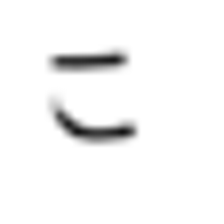

In [14]:
# Render tf
render_image_arr(np.array(final_results[0][0]) * 0.5 + 0.5)

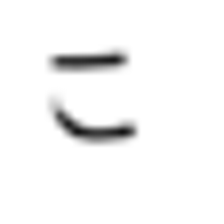

In [15]:
# Render torch
refined_torch_out = torch_out.detach().numpy() * 0.5 + 0.5

render_torch(refined_torch_out[0][0])